# An Application of Online EM Algorithm to Letter Prediction Problem

The implementation of HMM in large part belongs to Ali Taylan Cemgil(ATC): 
https://github.com/atcemgil/notes/blob/master/HiddenMarkovModel.ipynb

The code importing the data also belongs to ATC: https://github.com/atcemgil/notes/blob/master/Sampling.ipynb

## An Implementation of HMM in Python

### Some Utility Functions

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def randgen(pr, N=1): 
    L = len(pr)
    return np.random.choice(range(L), size=N, replace=True, p=pr)

def log_sum_exp(l, axis=0):
    l_star = np.max(l, axis=axis, keepdims=True)
    return l_star + np.log(np.sum(np.exp(l - l_star),axis=axis,keepdims=True)) 

def normalize_exp(log_P, axis=None):
    a = np.max(log_P, keepdims=True, axis=axis)
    P = normalize(np.exp(log_P - a), axis=axis)
    return P

def normalize(A, axis=None):
    Z = np.sum(A, axis=axis,keepdims=True)
    idx = np.where(Z == 0)
    Z[idx] = 1
    return A/Z


### Some HMM Functions

In [7]:
def predict(A, lp):
    lstar = np.max(lp)
    return lstar + np.log(np.dot(A,np.exp(lp-lstar)))

def postdict(A, lp):
    lstar = np.max(lp)
    return lstar + np.log(np.dot(np.exp(lp-lstar), A))

def update(y, logB, lp):
    return logB[y,:] + lp

### HMM Implementation 

In [8]:
class HMM(object):
    def __init__(self, pi, A, B):
        # p(x_0)
        self.pi = pi
        # p(x_k|x_{k-1})
        self.A = A
        # p(y_k|x_{k})
        self.B = B
        # Number of possible latent states at each time
        self.S = pi.shape[0]
        # Number of possible observations at each time
        self.R = B.shape[0]
        self.logB = np.log(self.B)
        self.logA = np.log(self.A)
        self.logpi = np.log(self.pi)
        
    def copy(self):
        pi_ = self.pi.copy()
        A_ = self.A.copy()
        B_ = self.B.copy()
        hmm = HMM(pi_,A_,B_)
        return hmm
    
    @classmethod
    def from_random_parameters(cls, S=3, R=5):
        A = np.random.dirichlet(0.7*np.ones(S),S).T
        B = np.random.dirichlet(0.7*np.ones(R),S).T
        pi = np.random.dirichlet(0.7*np.ones(S)).T
        return cls(pi, A, B)
    
    def eval_lhood(self,y):
        log_gamma = self.forward_backward_smoother(y)
        return log_sum_exp(log_gamma[:,0])
        
    def __str__(self):
        s = "Prior:\n" + str(self.pi) + "\nA:\n" + str(self.A) + "\nB:\n" + str(self.B)
        return s
    
    def __repr__(self):
        s = self.__str__()
        return s

    def predict(self, lp):
        lstar = np.max(lp)
        return lstar + np.log(np.dot(self.A,np.exp(lp-lstar)))

    def postdict(self, lp):
        lstar = np.max(lp)
        return lstar + np.log(np.dot(np.exp(lp-lstar), self.A))

    def update(self, y, lp):
        return self.logB[y,:] + lp

    def generate_sequence(self, T=10):
        # T: Number of steps
        x = np.zeros(T)
        y = np.zeros(T)

        for t in range(T):
            if t==0:
                x[t] = randgen(self.pi)
            else:
                x[t] = randgen(self.A[:,x[t-1]])    
            y[t] = randgen(self.B[:,x[t]])
    
        return y, x

    def forward(self, y):
        T = len(y)
        
        # Forward Pass

        # Python indexes starting from zero so
        # log \alpha_{k|k} will be in log_alpha[:,k-1]
        # log \alpha_{k|k-1} will be in log_alpha_pred[:,k-1]
        log_alpha  = np.zeros((self.S, T))
        log_alpha_pred = np.zeros((self.S, T))
        for k in range(T):
            if k==0:
                log_alpha_pred[:,0] = self.logpi
            else:
                log_alpha_pred[:,k] = self.predict(log_alpha[:,k-1])

            log_alpha[:,k] = self.update(y[k], log_alpha_pred[:,k])
            
        return log_alpha, log_alpha_pred
            
    def backward(self, y):
        # Backward Pass
        T = len(y)
        log_beta  = np.zeros((self.S, T))
        log_beta_post = np.zeros((self.S, T))

        for k in range(T-1,-1,-1):
            if k==T-1:
                log_beta_post[:,k] = np.zeros(self.S)
            else:
                log_beta_post[:,k] = self.postdict(log_beta[:,k+1])

            log_beta[:,k] = self.update(y[k], log_beta_post[:,k])

        return log_beta, log_beta_post
        
    def forward_backward_smoother(self, y):
        log_alpha, log_alpha_pred = self.forward(y)
        log_beta, log_beta_post = self.backward(y)
        
        log_gamma = log_alpha + log_beta_post
        return log_gamma
        
    def correction_smoother(self, y):
        # Correction Smoother

        log_alpha, log_alpha_pred = self.forward(y)
        T = len(y)
        
        # For numerical stability, we calculate everything in the log domain
        log_gamma_corr = np.zeros_like(log_alpha)
        log_gamma_corr[:,T-1] = log_alpha[:,T-1]

        C2 = np.zeros((self.S, self.S))
        C3 = np.zeros((self.R, self.S))
        C3[y[-1],:] = normalize_exp(log_alpha[:,T-1])
        for k in range(T-2,-1,-1):
            log_old_pairwise_marginal = log_alpha[:,k].reshape(1,self.S) + self.logA 
            log_old_marginal = self.predict(log_alpha[:,k])
            log_new_pairwise_marginal = log_old_pairwise_marginal + log_gamma_corr[:,k+1].reshape(self.S,1) - log_old_marginal.reshape(self.S,1)
            log_gamma_corr[:,k] = log_sum_exp(log_new_pairwise_marginal, axis=0).reshape(self.S)
            C2 += normalize_exp(log_new_pairwise_marginal)
            C3[y[k],:] += normalize_exp(log_gamma_corr[:,k])
        C1 = normalize_exp(log_gamma_corr[:,0])
        return C1, C2, C3, log_gamma_corr
    
    def forward_only_SS(self, y, V=None):
        # Forward only estimation of expected sufficient statistics
        T = len(y)
        
        if V is None:
            V1  = np.eye((self.S))
            V2  = np.zeros((self.S,self.S,self.S))
            V3  = np.zeros((self.R,self.S,self.S))
        else:
            V1, V2, V3 = V
            
        I_S1S = np.eye(self.S).reshape((self.S,1,self.S))
        I_RR = np.eye(self.R)
        
        for k in range(T):
            if k==0:
                log_alpha_pred = self.logpi
            else:
                log_alpha_pred = self.predict(log_alpha)

            if k>0:
                #print(self.S, self.R)
                #print(log_alpha)
                # Calculate p(x_{k-1}|y_{1:k-1}, x_k) 
                lp = np.log(normalize_exp(log_alpha)).reshape(self.S,1) + self.logA.T    
                P = normalize_exp(lp, axis=0)

                # Update
                V1 = np.dot(V1, P)             
                V2 = np.dot(V2, P) + I_S1S*P.reshape((1,self.S,self.S))    
                V3 = np.dot(V3, P) + I_RR[:,y[k-1]].reshape((self.R,1,1))*P.reshape((1,self.S,self.S))    

            log_alpha = self.update(y[k], log_alpha_pred)    
            p_xT = normalize_exp(log_alpha)    

        C1 = np.dot(V1, p_xT.reshape(self.S,1))
        C2 = np.dot(V2, p_xT.reshape(1,self.S,1)).reshape((self.S,self.S))
        C3 = np.dot(V3, p_xT.reshape(1,self.S,1)).reshape((self.R,self.S))
        C3[y[-1],:] +=  p_xT
        
        ll = log_sum_exp(log_alpha)
        
        return C1, C2, C3, ll, (V1, V2, V3)

    
    def train_EM(self, y, EPOCH=10, method=1):
        LL = np.zeros(EPOCH)
        for e in range(EPOCH):
            if method is 'correction_smoother':
                C1, C2, C3, log_gamma_corr = self.correction_smoother(y)
                ll = log_sum_exp(log_gamma_corr[:,0])
            elif method is 'forward_only':
                C1, C2, C3, ll, V = self.forward_only_SS(y)
            else:
                return
            LL[e] = ll
            p = normalize(C1 + 0.1, axis=0).reshape(self.S)
            # print(p,np.size(p))            
            A = normalize(C2, axis=0)
            # print(A)
            B = normalize(C3, axis=0)
            # print(B)
            self.__init__(p, A, B)
            
        return LL
    
    def online_em(self, y, V=None, n_min=100, gamma=0.2, gamma_const=0.999):
        T = len(y)
        LL = np.zeros(T)
        
        if V is None:
            V1  = np.eye((self.S))
            V2  = np.zeros((self.S,self.S,self.S))
            V3  = np.zeros((self.R,self.S,self.S))
        else:
            V1, V2, V3 = V
            
        I_S1S = np.eye(self.S).reshape((self.S,1,self.S))
        I_RR = np.eye(self.R)
        
        for k in range(T):
            # E step
            if k==0:
                log_alpha_pred = self.logpi
            else:
                log_alpha_pred = self.predict(log_alpha)

            if k>0:
                # Calculate p(x_{k-1}|y_{1:k-1}, x_k) 
                lp = np.log(normalize_exp(log_alpha)).reshape(self.S,1) + self.logA.T    
                P = normalize_exp(lp, axis=0)

                # Update
                V1 = np.dot(V1, P)             
                V2 = (1-gamma)*np.dot(V2, P) + gamma*I_S1S*P.reshape((1,self.S,self.S))    
                V3 = (1-gamma)*np.dot(V3, P) + gamma*I_RR[:,y[k-1]].reshape((self.R,1,1))*P.reshape((1,self.S,self.S))    

            log_alpha = self.update(y[k], log_alpha_pred)    
            p_xT = normalize_exp(log_alpha)    
        
            LL[k] = log_sum_exp(log_alpha)
            
            # M step
            if k > n_min:
                C1 = np.dot(V1, p_xT.reshape(self.S,1))
                C2 = np.dot(V2, p_xT.reshape(1,self.S,1)).reshape((self.S,self.S))
                C3 = np.dot(V3, p_xT.reshape(1,self.S,1)).reshape((self.R,self.S))
                C3[y[k],:] +=  p_xT
                
                p = normalize(C1 + 0.1, axis=0).reshape(self.S)
                A = normalize(C2, axis=0)
                B = normalize(C3, axis=0)
                self.__init__(p, A, B)
            
            if gamma > 1e-2:
                gamma *= gamma_const
    
        return LL
    
    
            

### Test Code

In [9]:
import time
hmm_original = HMM.from_random_parameters()
L = 10000
y,x = hmm_original.generate_sequence(L)

# init three random HMM's with the sama parameters
hmm = HMM.from_random_parameters()

beg = time.time()
# train the second one with forward only SS
LL3 = hmm.online_em(y)
print "online_em_lhood=%f, duration=%f" %(LL3[-1],time.time()-beg)

hmm_random = HMM.from_random_parameters()
print "random lhood:", hmm_random.eval_lhood(y)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:64: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:63: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:52: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


online_em_lhood=-15448.445738, duration=3.041157
random lhood: [-20204.57131669]


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:229: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:241: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [10]:
# init an hmm and generate data
import time
hmm_original = HMM.from_random_parameters()
L = 1000
y,x = hmm_original.generate_sequence(L)


beg = time.time()
# eval likelihood with the original params
LL = hmm_original.train_EM(y, EPOCH=50, method='correction_smoother')
print "original_lhood=%f, duration=%f" %(LL[-1],time.time()-beg)
# plt.plot(LL)
# plt.show()

# init three random HMM's with the sama parameters
hmm1 = HMM.from_random_parameters()
hmm2 = hmm1.copy()
hmm3 = hmm1.copy()

beg = time.time()
# train the first one with correction smoother
LL1 = hmm1.train_EM(y, EPOCH=50, method='correction_smoother')
print "correction_smoother_lhood=%f, duration=%f" %(LL1[-1],time.time()-beg)
# plt.plot(LL1)
# plt.show()

beg = time.time()
# train the second one with forward only SS
LL2 = hmm2.train_EM(y, EPOCH=50, method='forward_only')
print "forward_only_ss_lhood=%f, duration=%f" %(LL2[-1],time.time()-beg)
# plt.plot(LL2)
# plt.show()
# print "hmm2:",hmm2,"\n"

beg = time.time()
# train the second one with forward only SS
LL3 = hmm3.online_em(y)
print "online_em_lhood=%f, duration=%f" %(LL3[-1],time.time()-beg)
# plt.plot(LL3)
# plt.show()


hmm_random = HMM.from_random_parameters()
log_gamma = hmm_random.forward_backward_smoother(y)
print "random lhood:",log_sum_exp(log_gamma[:,0])

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:64: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:63: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:52: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


original_lhood=-1387.765107, duration=9.069985
correction_smoother_lhood=-1424.921046, duration=8.959090

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:123: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:130: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:164: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



forward_only_ss_lhood=-1424.921046, duration=7.841359

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:172: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:229: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



online_em_lhood=-1693.998292, duration=0.299935
random lhood: [-1890.78872614]


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:241: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


### Test Code - 2

In [11]:
hmm = HMM.from_random_parameters()

L = 300

y,x = hmm.generate_sequence(L)

print("Results with the Forward Smoother")
C1, C2, C3, ll, V = hmm.forward_only_SS(y)
    
print(C1)
print(np.sum(C1))

print(C2)
print(np.sum(C2))

print(C3)
print(np.sum(C3))

print("Results with the Correction Smoother")
C1_corr, C2_corr, C3_corr, lg = hmm.correction_smoother(y)

print(C1_corr)
print(np.sum(C1_corr))

print(C2_corr)
print(np.sum(C2_corr))

print(C3_corr)
print(np.sum(C3_corr))

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:64: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:63: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:52: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Results with the Forward Smoother
[[  1.32212733e-02]
 [  9.86698546e-01]
 [  8.01802557e-05]]
1.0
[[  5.91202728  29.67219766  29.45631193]
 [ 45.75258899  54.71403833  50.66886794]
 [ 13.05584544  67.36475011   2.40337231]]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:164: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:172: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:123: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



299.0
[[  1.79443232e+01   1.19462123e+02   2.59355424e+00]
 [  2.05176866e+00   2.09113826e+00   1.38570931e+01]
 [  1.91951953e+01   2.37243939e+01   1.00804108e+01]
 [  2.39051172e-01   2.45754331e-02   6.73637339e+00]
 [  2.56234198e+01   6.81996366e+00   4.95566165e+01]]
300.0
Results with the Correction Smoother
[  1.32212733e-02   9.86698546e-01   8.01802557e-05]
1.0
[[  5.91202728  29.67219766  29.45631193]
 [ 45.75258899  54.71403833  50.66886794]
 [ 13.05584544  67.36475011   2.40337231]]
299.0
[[  1.79443232e+01   1.19462123e+02   2.59355424e+00]
 [  2.05176866e+00   2.09113826e+00   1.38570931e+01]
 [  1.91951953e+01   2.37243939e+01   1.00804108e+01]
 [  2.39051172e-01   2.45754331e-02   6.73637339e+00]
 [  2.56234198e+01   6.81996366e+00   4.95566165e+01]]
300.0


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:130: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


# Data Sets

### Counting letter bigrams in several languages

In [25]:
%matplotlib inline
from collections import defaultdict
import urllib2
import string
import numpy as np
import matplotlib.pyplot as plt
from string import maketrans   # Required to call maketrans function.

# Turkish
#"ç","ı","ğ","ö","ş","ü",'â'
# German
#"ä","ß","ö","ü"
# French
#"ù","û","ô","â","à","ç","é","è","ê","ë","î","ï","æ"
tr_alphabet = ['*','a','b','c','ç','d','e','f',
                'g','ğ','h','ı','i','j','k','l',
                'm','n','o','ö','p','q','r','s','ş',
                't','u','ü','w','v','x','y','z']
# Union of Frequent letters in French, Turkish, German and English
my_alphabet = ['*','a','â','ä',"à","æ",'b','c','ç','d','e',"é","è","ê","ë",'f',
                'g','ğ','h','ı','i',"î",'ï','j','k','l',
                'm','n','o','œ',"ô",'ö','p','q','r','s','ş',
                't','u','ù',"û",'ü','w','v','x','y','z','ß']
# Only ascii characters
ascii_alphabet = list('*'+string.ascii_lowercase)
# Reduction table from my alphabet to ascii
my2ascii_table = {
    ord(u"â"):u"a",
    ord(u"ä"):u"ae",
    ord(u"à"):u"a",
    ord(u"æ"):u"ae",
    ord(u"À"):u"a",
    ord(u"Æ"):u"a",
    ord(u"ç"):u"c",
    ord(u"Ç"):u"c",
    ord(u"é"):u"e",
    ord(u"è"):u"e",
    ord(u"ê"):u"e",
    ord(u"ë"):u"e",
    ord(u"È"):u"e",
    ord(u"Ê"):u"e",
    ord(u"É"):u"e",
    ord(u"Ë"):u"e",
    ord(u'ğ'):u"g",
    ord(u'ı'):u"i",
    ord(u"î"):u"i",
    ord(u"İ"):u"i",
    ord(u'ï'):u"i",
    ord(u'œ'):u"oe",
    ord(u"Ô"):u"o",
    ord(u"ô"):u"o",
    ord(u'Ö'):u"o",
    ord(u'ö'):u"o",
    ord(u'ş'):u"s",
    ord(u'Ş'):u"s",
    ord(u'ù'):u"u",
    ord(u"û"):u"u",
    ord(u'ü'):u"u",
    ord(u'Ü'):u"u",
    ord(u'ß'):u"ss"
    }
# Reduction table from my alphabet to frequent letters in turkish text
my2tr_table = {
    ord(u'â'):u"a",
    ord(u'ä'):u"ae",
    ord(u"à"):u"a",
    ord(u"æ"):u"ae",
    ord(u"é"):u"e",
    ord(u"è"):u"e",
    ord(u"ê"):u"e",
    ord(u"ë"):u"e",
    ord(u"î"):u"i",
    ord(u'ı'):u"i",
    ord(u'I'):u"i",
    ord(u'ï'):u"i",
    ord(u'ş'):u"s",
    ord(u'Ş'):u"s",
    ord(u"ç"):u"c",
    ord(u"Ç"):u"c",
    ord(u'ğ'):u"g",
    ord(u'ü'):u"u",
    ord(u'œ'):u"oe",
    ord(u"ô"):u"o",
    ord(u'ù'):u"u",
    ord(u"û"):u"u",
    ord(u'ß'):u"ss"
    }


def count_transitions(fpp, alphabet, tab):

    #ignore punctuation
    rep_chars = '.\t\n\rİ»«…’°” '
    tbrep = dict((ord(char), u"*") for char in rep_chars)
    
    delete_chars = '0123456789!"\'#$%&\(\),-/:;<=>?@[\\]^_`{|}~+'
    tbdel = dict((ord(char), None) for char in delete_chars)
    
    #replace other unicode characters with a star

    # Character pairs 
    D = defaultdict(int)

    for line in fpp:
        # s = line.decode('utf-8').translate(tb).lower()
        s = line.lower().decode('utf-8', 'ignore')
        s = s.translate(tbdel)
        s = s.translate(tbrep)
        s = s.translate(tab)

        if len(s)>1:
            for i in range(len(s)-1):
                D[s[i:i+2]]+=1
    
    M = len(alphabet)
    a2i = {v: k for k,v in enumerate(alphabet)}
    DD = np.zeros((M,M))
    
    miss = 0
    ky = sorted(D.keys())
    for k in D.keys():
        try:
            i = a2i[k[0]]
            j = a2i[k[1]]
            DD[i,j] = D[k]
        except:
            miss += 1
            # print k[0], k[1]
    print "miss is %d" % miss

    return D, DD, alphabet

### Count and display occurences of letters in text

t ’
’ m
g ’
’ a
t …
… s
… d
z …
… *
… ”
’ i
’ l
’ n
’ e
’ d
’ y
’ u
’ t
s ’
y …
l ’
l …
r ”
e …
r …
e ’
k …
* “
d ’
” *
“ p
“ b
c ’
i …
i ’
o ’
u …
a …
n …
a ’
miss is 40
﻿ p
miss is 1
﻿ t
miss is 1
miss is 0
miss is 0
miss is 0
miss is 0
miss is 0


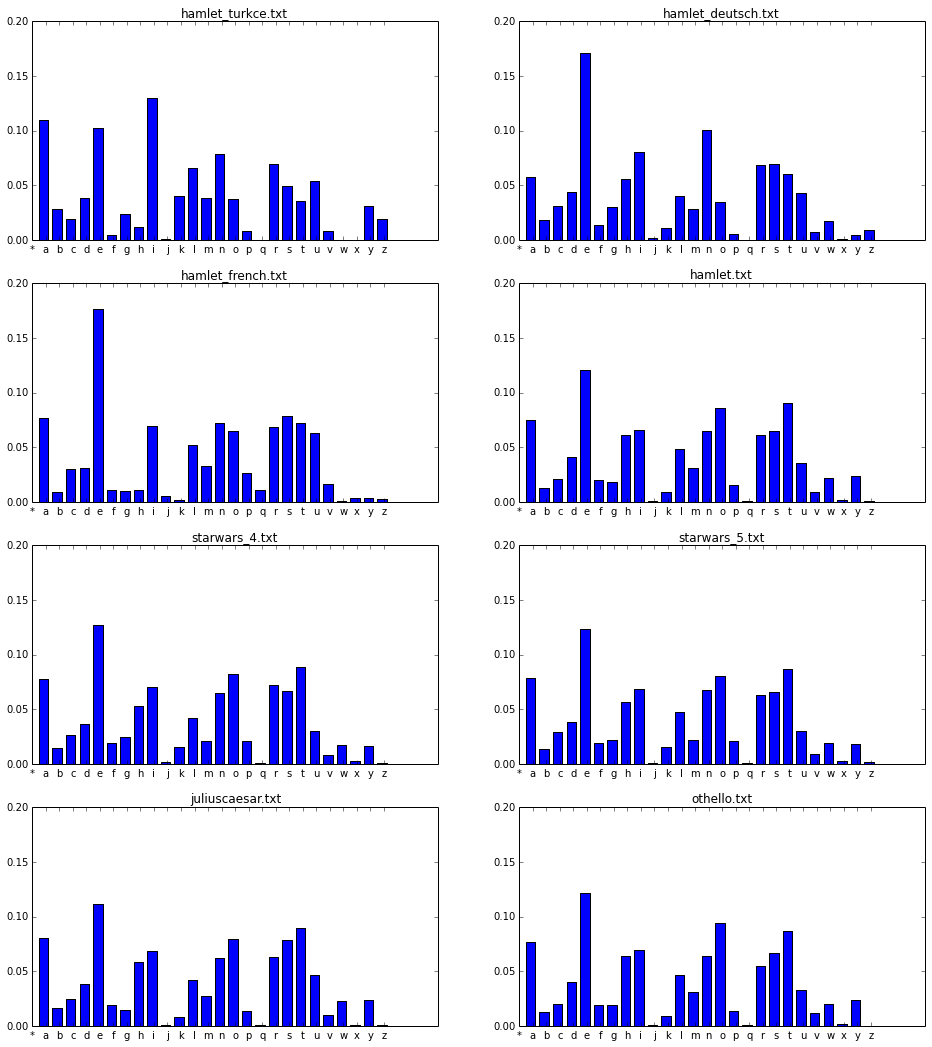

In [13]:
local = 'data/'
#local = 'https://dl.dropboxusercontent.com/u/9787379/swe546/data/'
#files = ['starwars_4.txt', 'starwars_5.txt', 'starwars_6.txt', 'hamlet.txt','hamlet_deutsch.txt', 'hamlet_french.txt', 'juliuscaesar.txt','othello.txt', 'sonnets.txt', 'antoniusandcleopatra.txt']
files = ['hamlet_turkce.txt','hamlet_deutsch.txt', 'hamlet_french.txt', 'hamlet.txt','starwars_4.txt', 'starwars_5.txt','juliuscaesar.txt','othello.txt']

plt.figure(figsize=(16,18))

i = 0
for f in files:
    path = local+f
    # data = urlopen(url) 
    # data = urllib2.urlopen(url).read()
    data = open(path,"rb")
    #D, DD, alphabet = count_transitions(data, my_alphabet, {})
    D, DD, alphabet = count_transitions(data, ascii_alphabet, my2ascii_table)
    #D, DD, alphabet = count_transitions(data, tr_alphabet, my2tr_table)
    M = len(alphabet)
    # Ignore space, space transitions
    DD[0,0] = 1
    
    i+=1
    plt.subplot(len(files)/2,2,i)
        
    S = np.sum(DD,axis=0)
    #Subpress spaces
    S[0] = 0
    S = S/np.sum(S)

    plt.bar(np.arange(M)-0.5, S, width=0.7)
    plt.xticks(range(M), alphabet)
    plt.gca().set_ylim((0,0.2))
    plt.title(f)

plt.show()

### Counting Bigrams 

miss is 40
miss is 1
miss is 1
miss is 0
miss is 0
miss is 0
miss is 0
miss is 0


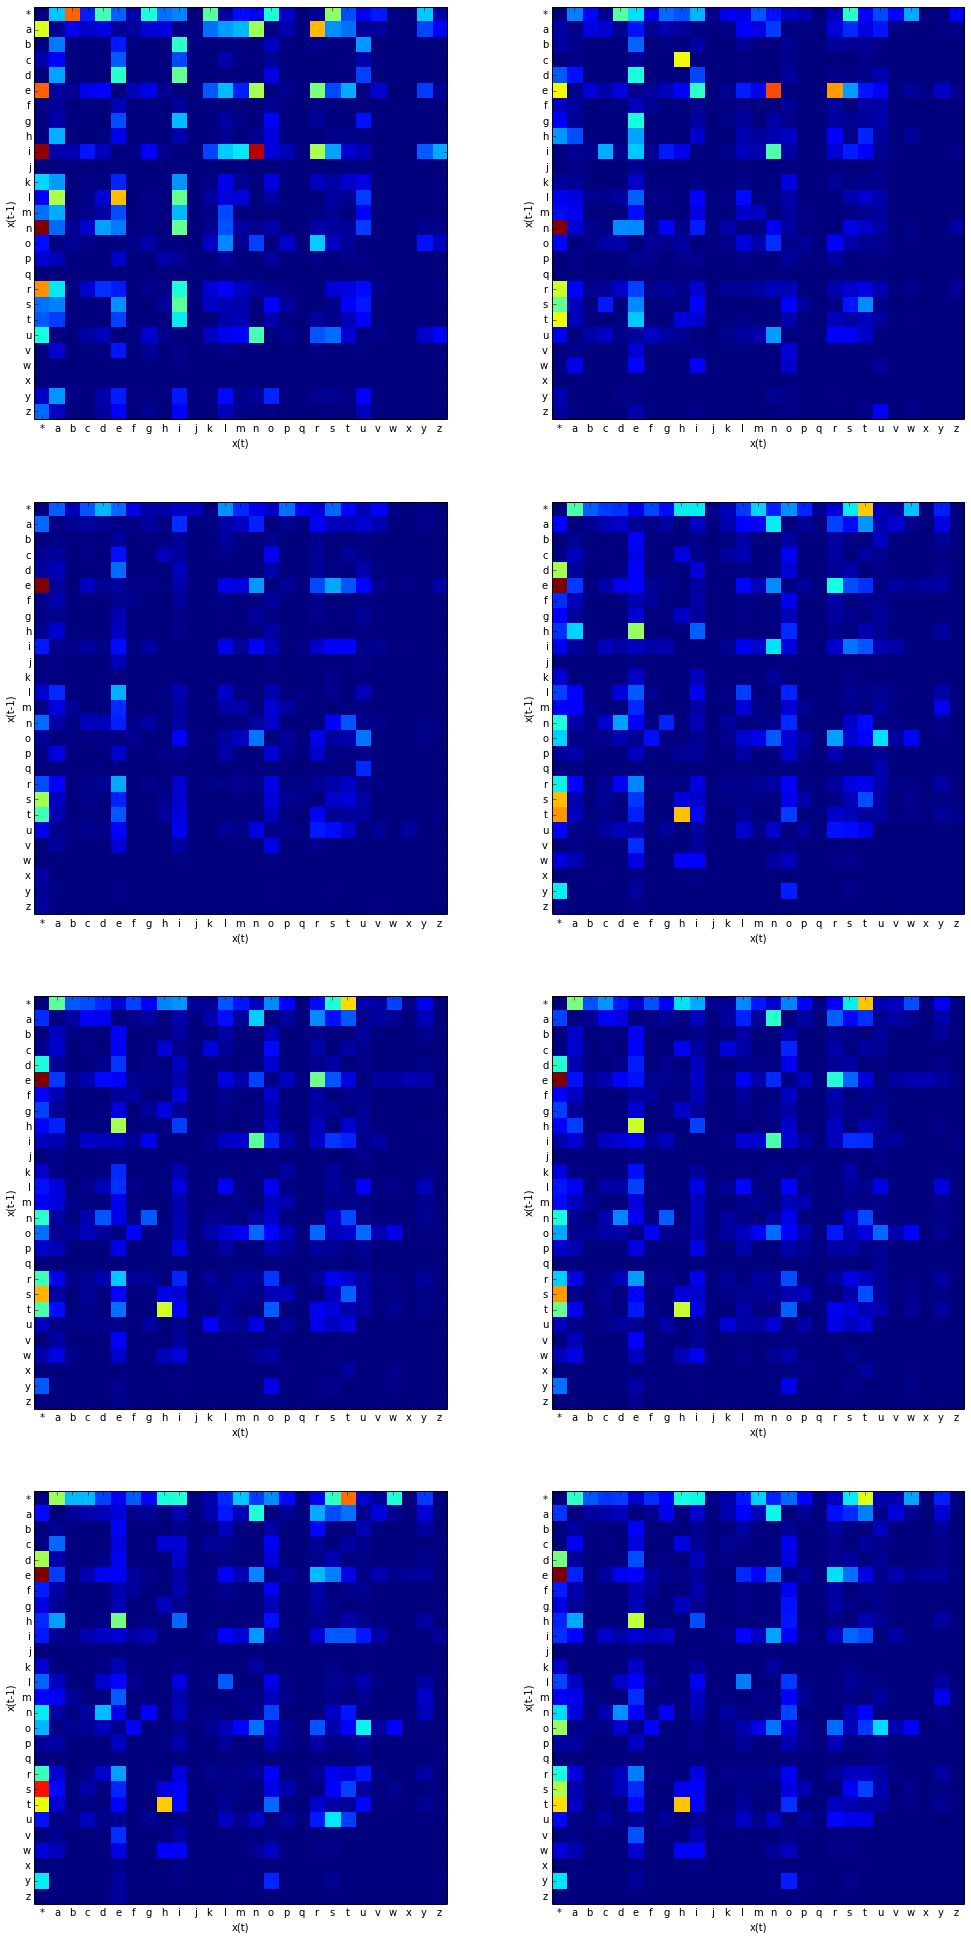

In [26]:
local = 'data/'
#local = 'https://dl.dropboxusercontent.com/u/9787379/swe546/data/'

#files = ['starwars_4.txt', 'starwars_5.txt', 'starwars_6.txt', 'hamlet.txt', 'hamlet_deutsch.txt', 'hamlet_french.txt', 'juliuscaesar.txt','othello.txt', 'sonnets.txt', 'antoniusandcleopatra.txt']
files = ['hamlet_turkce.txt','hamlet_deutsch.txt', 'hamlet_french.txt', 'hamlet.txt','starwars_4.txt', 'starwars_5.txt','juliuscaesar.txt','othello.txt']

plt.figure(figsize=(17,2*17))

i = 0
for f in files: 
    path = local+f
    data = open(path,"rb")
    D, DD, alphabet = count_transitions(data, ascii_alphabet, my2ascii_table)
    # D, DD, alphabet = count_transitions(data, tr_alphabet, my2tr_table)
    M = len(alphabet)
    DD[0,0] = 1
    
    
    i+=1
    plt.subplot(len(files)/2,2,i)
    plt.imshow(DD, interpolation='nearest', vmin=0)
    plt.xticks(range(M), alphabet)
    plt.xlabel('x(t)')
    plt.yticks(range(M), alphabet)
    plt.ylabel('x(t-1)')
    '''
    ax = plt.gca()
    ax.xaxis.tick_top()
    #ax.set_title(f, va='bottom')
    plt.xlabel('x(t) '+f)
    '''
    

### Normalized probability table of $p(x_t|x_{t−1})$

In [ ]:
def normalize(A, axis=0):
    Z = np.sum(A, axis=axis,keepdims=True)
    idx = np.where(Z == 0)
    Z[idx] = 1
    return A/Z

local = 'data/'
#local = 'https://dl.dropboxusercontent.com/u/9787379/swe546/data/'

file = 'hamlet_turkce.txt'
data = urlopen(local+file) 
D, DD, alphabet = count_transitions(data, tr_alphabet, my2tr_table)


plt.figure(figsize=(9,9))

T = normalize(DD, axis=1)


plt.imshow(T, interpolation='nearest', vmin=0)
plt.xticks(range(M), alphabet)
plt.yticks(range(M), alphabet)
plt.gca().xaxis.tick_top()

plt.show()